In [1]:
%matplotlib notebook
# import the necessary packages
from imutils.video import VideoStream, FileVideoStream
from imutils import face_utils
import datetime
import argparse
import imutils
import time
import dlib
import cv2
from collections import OrderedDict
import numpy as np
import sys
from pose_estimator import PoseEstimator
from stabilizer import Stabilizer
import matplotlib.pyplot as plt
import math

In [2]:
FACIAL_LANDMARKS_IDXS = OrderedDict([
    ("nose", (27, 36)),
    ("face", (0, 26))
])

In [3]:
def visualize_facial_landmarks(image, shape, colors=None, alpha=0.75):
    # create two copies of the input image -- one for the
    # overlay and one for the final output image
    overlay = image.copy()
    output = image.copy()

    # if the colors list is None, initialize it with a unique
    # color for each facial landmark region
    if colors is None:
        colors = [(255, 255, 255), (0, 0, 0), (0, 0, 0), (0, 0, 0),
            (0, 0, 0), (0, 0, 0),
            (0, 0, 0), (0, 0, 0), (255, 255, 255)]
        colors = [(19, 199, 109), (79, 76, 240), (230, 159, 23),
            (168, 100, 168), (158, 163, 32),
            (163, 38, 32), (180, 42, 220), (100, 150, 250)]

    # loop over the facial landmark regions individually
    for (i, name) in enumerate(FACIAL_LANDMARKS_IDXS.keys()):
        # grab the (x, y)-coordinates associated with the
        # face landmark
        (j, k) = FACIAL_LANDMARKS_IDXS[name]
        pts = shape[j:k]

        # check if are supposed to draw the jawline
        if name == "jaw":
            # since the jawline is a non-enclosed facial region,
            # just draw lines between the (x, y)-coordinates
            for l in range(1, len(pts)):
                ptA = tuple(pts[l - 1])
                ptB = tuple(pts[l])
                cv2.line(overlay, ptA, ptB, colors[i], 2)

        # otherwise, compute the convex hull of the facial
        # landmark coordinates points and display it
        else:
            if name == 'face':
                hull = cv2.convexHull(pts)
                cv2.drawContours(overlay, [hull], -1, colors[i], -1)

    # apply the transparent overlay
    cv2.addWeighted(overlay, alpha, output, 1 - alpha, 0, output)

    # return the output image
    return output

In [4]:
# initialize dlib's face detector (HOG-based) and then create
# the facial landmark predictor
detector = dlib.get_frontal_face_detector()
predictor_path = "../detect-face-parts/shape_predictor_68_face_landmarks.dat"
predictor = dlib.shape_predictor(predictor_path)

filename = '../data/cohface/1/0/data.avi'
filename = None
if filename:
    vs = FileVideoStream(filename).start()
else:
    vs = VideoStream(src=0).start()

In [5]:
def isclose(x, y, rtol=1.e-5, atol=1.e-8):
    return abs(x-y) <= atol + rtol * abs(y)

def euler_angles_from_rotation_matrix(R):
    '''
    From a paper by Gregory G. Slabaugh (undated),
    "Computing Euler angles from a rotation matrix
    '''
    phi = 0.0
    if isclose(R[2,0],-1.0):
        theta = math.pi/2.0
        psi = math.atan2(R[0,1],R[0,2])
    elif isclose(R[2,0],1.0):
        theta = -math.pi/2.0
        psi = math.atan2(-R[0,1],-R[0,2])
    else:
        theta = -math.asin(R[2,0])
        cos_theta = math.cos(theta)
        psi = math.atan2(R[2,1]/cos_theta, R[2,2]/cos_theta)
        phi = math.atan2(R[1,0]/cos_theta, R[0,0]/cos_theta)
    return psi, theta, phi

In [6]:
# initialize the video stream and allow the cammera sensor to warmup
print("[INFO] camera sensor warming up...")
time.sleep(2.0)

# loop over the frames from the video stream
first_pass = True

# set up plotting
r = []
g = []
b = []
roll = []
pitch = []
yaw = []
    
while True:
    # grab the frame from the threaded video stream, resize it to
    # have a maximum width of 400 pixels, and convert it to
    # grayscale
    if first_pass:
#         height, width = frame.shape[:2]
        height, width = 300, 400
        pose_estimator = PoseEstimator(img_size=(height, width))
        first_pass = False
        # Introduce scalar stabilizers for pose.
        pose_stabilizers = [Stabilizer(
        state_num=2,
        measure_num=1,
        cov_process=0.1,
        cov_measure=0.1) for _ in range(6)]
        
    frame = vs.read()
    frame = imutils.resize(frame, width=400)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # detect faces in the grayscale frame
    rects = detector(gray, 0)

    # loop over the face detections
    for rect in rects:
        # get the bounding box
        (bX, bY, bW, bH) = face_utils.rect_to_bb(rect)
        box_im = frame[bY:bH+bY, bX:bW+bX,:]
        # determine the facial landmarks for the face region, then
        # convert the facial landmark (x, y)-coordinates to a NumPy
        # array
        shape = face_utils.shape_to_np(predictor(gray, rect))

        # Try pose estimation with 68 points.
        pose = pose_estimator.solve_pose_by_68_points(shape.astype('float'))
        
        # Stabilize the pose.
        steady_pose = []
        pose_np = np.array(pose).flatten()
        for value, ps_stb in zip(pose_np, pose_stabilizers):
            ps_stb.update([value])
            steady_pose.append(ps_stb.state[0])
        steady_pose = np.reshape(steady_pose, (-1, 3))
        
#         print('0',steady_pose[0], '1',steady_pose[1])
        # rod vector to roll, pitch, yaw
        rot_mat = cv2.Rodrigues(steady_pose[0])[0]
        
        roll.append(steady_pose[0][0])
        pitch.append(steady_pose[0][1])
        yaw.append(steady_pose[0][2])
        # add values
#         roll.append(steady_pose[0][0] * np.pi)
#         pitch.append(steady_pose[0][1] * np.pi)
#         yaw.append(steady_pose[0][2] * np.pi)
#         print(' Roll: {:.2f}°'.format(roll))
#         print('Pitch: {:.2f}°'.format(pitch))
#         print('  Yaw: {:.2f}°'.format(yaw))


        # loop over the (x, y)-coordinates for the facial landmarks
        # and draw them on the image
        for (x, y) in shape:
            cv2.circle(frame, (x, y), 1, (0, 0, 255), -1)
            
        # loop over the face parts individually and draw them 
        for (name, (i, j)) in FACIAL_LANDMARKS_IDXS.items():
            # clone the original image so we can draw on it, then
            # display the name of the face part on the image
            clone = frame.copy()
            cv2.putText(clone, name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
                0.7, (0, 0, 255), 2)

            # loop over the subset of facial landmarks, drawing the
            # specific face part
            for (x, y) in shape[i:j]:
                cv2.circle(clone, (x, y), 1, (0, 0, 255), -1)
                


            # extract the ROI of the face region as a separate image
#             (x, y, w, h) = cv2.boundingRect(np.array([shape[i:j]]))
#             roi = frame[y:y + h, x:x + w]
#             roi = imutils.resize(roi, width=250, inter=cv2.INTER_CUBIC)
            

    # visualize all facial landmarks with a transparent overlay
#     output = visualize_facial_landmarks(frame, shape)
    frame_unstable = frame.copy()
    # Uncomment following line to draw pose annotation on frame.
    pose_estimator.draw_annotation_box(frame_unstable, pose[0], pose[1], color=(255, 128, 128))
    # Uncomment following line to draw stabile pose annotation on frame.
    pose_estimator.draw_annotation_box(frame, steady_pose[0], steady_pose[1], color=(128, 255, 128))
    # Uncomment following line to draw head axes on frame.
#     pose_estimator.draw_axes(output, steady_pose[0], steady_pose[1])
#     cv2.imshow("Frame", frame)
#     cv2.imshow("Frame unstable", frame_unstable)
    # Show box
    cv2.imshow("Box", box_im)
#     # show the particular face part
#     cv2.imshow("ROI", roi)
#     cv2.imshow("ROI", clone) 
    # plot
#     num_frames = range(len(roll))
#     plt.plot(num_frames, roll, color='red', label = 'roll')
#     plt.plot(num_frames, pitch, color='green', label='pitch')
#     plt.plot(num_frames, yaw, color='blue', label='yaw')
    key = cv2.waitKey(1) & 0xFF

    # if the `q` key was pressed, break from the loop
    if key == ord("q"):
        # do some cleanup
        cv2.destroyAllWindows()
        vs.stop()
        break
del vs 

[INFO] camera sensor warming up...
successful init


<IPython.core.display.Javascript object>


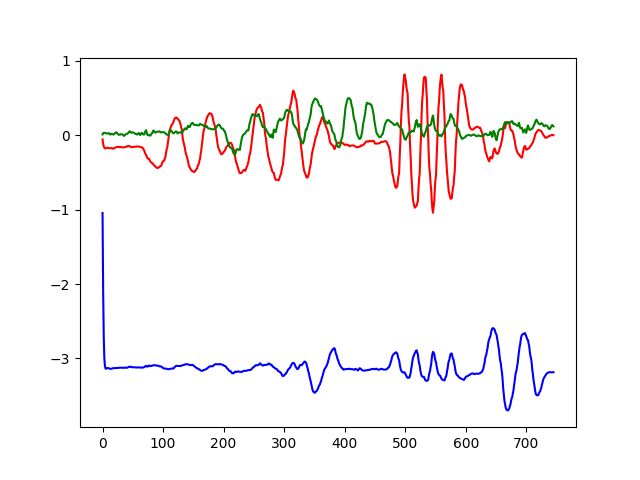

In [7]:
num_frames = range(len(roll))
plt.plot(num_frames, roll, color='red', label = 'roll')
plt.plot(num_frames, pitch, color='green', label='pitch')
plt.plot(num_frames, yaw, color='blue', label='yaw')

In [8]:
raw_value = []
with open('assets/model.txt') as file:
    for line in file:
        raw_value.append(line)
model_points = np.array(raw_value, dtype=np.float32)
model_points = np.reshape(model_points, (3, -1)).T

# Transform the model into a front view.
model_points[:, 2] *= -1

# Camera internals
focal_length = 400
camera_center = (400 / 2, 300 / 2)
camera_matrix = np.array(
    [[focal_length, 0, camera_center[0]],
     [0, focal_length, camera_center[1]],
     [0, 0, 1]], dtype="double")

# Assuming no lens distortion
dist_coeefs = np.zeros((4, 1))

# Rotation vector and translation vector
r_vec = np.array([[0.01891013], [0.08560084], [-3.14392813]])
t_vec = np.array([[-14.97821226], [-10.62040383], [-2053.03596872]])

def solve_pose_by_68_points(image_points):
    """
    Solve pose from all the 68 image points
    Return (rotation_vector, translation_vector) as pose.
    """

    (_, rotation_vector, translation_vector) = cv2.solvePnP(
        model_points,
        image_points,
        camera_matrix,
        dist_coeefs,
        rvec=r_vec,
        tvec=t_vec,
        useExtrinsicGuess=True)

    return (rotation_vector, translation_vector)
